# Analysis of an A/B test - improved recommendation system

## Purposes of the Study
The purpose of this study is to analyze the results of an A/B test for an improved recommendation system.

This will be done based on the online store's data, consisting of information on the users and their actions. The data include unique user identifier and their experiment group, as well as the user's region, the date of their sign-up and the device used to sign up. It also includes the action (event) name and time and the order total. In addition the calendar of marketing events will also be taken into account. This includes the name of the marketing event, regions where the ad campaign was held and the campaign start and end date.

The actions I'm planning to take are as following:
* Explore and preprocess initial data 
* Carry out exploratory data analysis: study and check the data in general & the event funnel in particular
* Evaluate the A/B test results
* Draw conclusions


### Task statement

Your predecessor launched an A/B test and then quit. They left only the technical specifications and the test results.
See whether the test was carried out correctly, and analyze the results. 

**Technical description**

- Test name: `recommender_system_test`
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.
- Expected number of test participants: 6000

## Initialization

In [1]:
import pandas as pd
import numpy as np
import sidetable
from statsmodels.stats.proportion import proportions_ztest
from random import sample

import plotly.express as px
from plotly import graph_objects as go

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
# Reading the data
marketing_events = pd.read_csv('ab_project_marketing_events.csv')
marketing_events.to_csv('ab_project_marketing_events.csv', index=False)

new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
new_users.to_csv('final_ab_new_users_upd_us.csv', index=False)

events = pd.read_csv('final_ab_events_upd_us.csv')
events.to_csv('final_ab_events_upd_us.csv', index=False)

participants = pd.read_csv('final_ab_participants_upd_us.csv')
participants.to_csv('final_ab_participants_upd_us.csv', index=False)

## Exploring and preprocessing the data

### Marketing data

In [3]:
# Examining the marketing data 
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
# Checking the marketing data info
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


- `start_dt` and `finish-dt` are objects instead of datetime type, but it doesn't matter in this case because we are not going to perform any actions with this data.
- I will get back to this data in the EDA stage.

### New users data

In [5]:
# Examining a sample of the new_users data 
new_users.sample(5)

,user_id,first_date,region,device
25088,6202E7A556AC570E,2020-12-22,APAC,Android
56193,D36724C5A3AFAF36,2020-12-20,APAC,iPhone
2846,C7BA3ECD51FD5FBC,2020-12-07,EU,Android
2047,CA0F4AA2019807B9,2020-12-07,EU,iPhone
24220,BEA28F1E762B11F0,2020-12-22,EU,PC


In [6]:
# Checking the new_users data info
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


- `first_date` is an object instead of a datetime type.
- No missing values.

In [7]:
# Converting `first_date` column to a datetime type
new_users.first_date = pd.to_datetime(new_users.first_date)

In [8]:
# Examining the descriptive statistics of the new_users data 
new_users.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
user_id,58703,58703,D72A72121175D8BE,1,NaT,NaT,NaT,NaT,NaT,NaT
first_date,58703,NaN,NaN,NaN,2020-12-15 01:59:36.573599488,2020-12-07,2020-12-11,2020-12-15,2020-12-20,2020-12-23
region,58703,4,EU,43396,NaT,NaT,NaT,NaT,NaT,NaT
device,58703,4,Android,26159,NaT,NaT,NaT,NaT,NaT,NaT


- There are 58,703 new users.
- Assigning new users for the test was supposed to be in the period of 7-21.12.2020, but the data ends two days later.
- There are 4 users' regions, the top is EU.
- There are 4 devices used to sign up, the top is Android.

In [9]:
new_users.duplicated().sum()

0

### Events data

In [10]:
# Examining a sample of the events data 
events.sample(5)

,user_id,event_dt,event_name,details
177902,5F30F5E0A679D5D1,2020-12-18 07:17:05,product_page,NaN
412535,0E31F3239E9589D8,2020-12-27 21:28:44,login,NaN
381593,8869E548C131599E,2020-12-22 19:06:17,login,NaN
45541,6FC81FA157DD45B6,2020-12-22 01:22:56,purchase,4.99
278264,5506264DF1DBE3A0,2020-12-13 21:34:05,login,NaN


In [11]:
# Checking the events data info
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


- `event_dt` is an object instead of a datetime type.
- It would be beneficial to have the date of the event seperately from the exact time.
- Only a small part of the events have details. Perhaps only purchases have them?

In [12]:
# Converting `event_dt` column to a datetime type and extracting the date
events.event_dt = pd.to_datetime(events.event_dt)
events['session_date'] = events.event_dt.astype('datetime64[D]')
events.head()

,user_id,event_dt,event_name,details,session_date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


In [13]:
# Checking whether the details coincide with the purchases (meaning the order total)
"Missing details:"
events[events['details'].isnull()]['event_name'].value_counts()
"Non-missing details:"
events[events['details'].notna()]['event_name'].value_counts()

'Missing details:'

login           182465
product_page    120862
product_cart     60120
Name: event_name, dtype: int64

'Non-missing details:'

purchase    60314
Name: event_name, dtype: int64

In [14]:
# Examining the descriptive statistics of the events data 
events.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,423761,58703,A3917F81482141F2,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_dt,423761,NaN,NaN,NaN,2020-12-18 10:10:17.282395648,2020-12-07 00:00:33,2020-12-14 03:05:18,2020-12-18 17:40:52,2020-12-22 13:51:17,2020-12-30 23:36:33,NaN
event_name,423761,4,login,182465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
details,60314.0,NaN,NaN,NaN,23.881219,4.99,4.99,4.99,9.99,499.99,72.228884
session_date,423761,NaN,NaN,NaN,2020-12-17 22:10:29.081014784,2020-12-07 00:00:00,2020-12-14 00:00:00,2020-12-18 00:00:00,2020-12-22 00:00:00,2020-12-30 00:00:00,NaN


- There are 58,703 users - the same as in the new_users data.
- Data was supposed to represent the events within the period 7.12.2020 - 1.1.2021, but in fact it doesn't include 1.1.2021 (end date is 30.12.2020).
- There are 4 events or types of user actions. The top is login.

In [15]:
events.duplicated().sum()

0

### Participants data

In [16]:
# Checking the participants data info
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [17]:
# Examining a sample of the participants data 
participants.sample(5)

,user_id,group,ab_test
13749,D735D2EAC9C25BA1,A,interface_eu_test
11121,E8909F60D7833CFD,B,interface_eu_test
9265,15DAE225AF7DAC6B,B,interface_eu_test
10881,8D8BA554EEA66B9C,A,interface_eu_test
648,C729D0E3D2A3D492,A,recommender_system_test


In [18]:
participants.describe(include='all').T

,count,unique,top,freq
user_id,14525,13638,307C06C0E6F09B93,2
group,14525,2,A,8214
ab_test,14525,2,interface_eu_test,10850


- There are only 13,638 users who were assigned to an A/B test (in comparison to 58,703 new users in total).
- There are two groups, top one is A.
- There's no explicit A/A test.
- There are two A/B tests, not just the one we're interested in. In fact most of the users participated in the second test (`interface_eu_test`).

In [19]:
# Checking double assignments of users to tests
double_tests = participants.groupby('user_id').agg({'ab_test':'count'}).query('ab_test >1').reset_index()
f"There are {len(double_tests)} users who were assigned to more than one test"

'There are 887 users who were assigned to more than one test'

- Users who were assigned to both of the tests simultaneously should be removed altogether, because it's impossible to isolate the effects of any of the tests. 

In [20]:
# Another way to look at the "double tests' users"
participants.duplicated(subset=['user_id']).sum()

887

In [21]:
# Excluding the "double tests' users"
valid_participants = participants.drop_duplicates(subset=['user_id'], keep=False)
f"There are {valid_participants.user_id.nunique()} valid users"

'There are 12751 valid users'

In [22]:
# Making sure that there's no double assignment of users to groups
valid_participants.groupby('user_id').agg({'group':'count'}).query('group >1')

,group
user_id,


### Summary of preprocess

- Converted relevant columns to datetime type.
<br>
- Found missing details about events - they appear only for purchases.
<br>

- Data about new users and their actions is for 58,703 users. Only 13,638 users were assigned to an A/B test. 887 of them were mistakenly assigned to two tests simultaneously, meaning there are 12,751 valid participants overall. However, they were assigned to two different A/B tests.
<br>
- There's no explicit A/A test.
<br>
- Assigning new users for the test was supposed to be in the period of 7-21.12.2020 according to the technical description, but the signing-up data ends two days later.
<br>
- Data about the events was supposed to be collected during 7.12.2020 - 1.1.2021, but in fact it doesn't include 1.1.2021 (end date is 30.12.2020).


## Exploratory data analysis

### Analysing dates

In [23]:
# Sorting marketing events by date
marketing_events = marketing_events.sort_values(by='start_dt',ascending=False)
marketing_events

,name,regions,start_dt,finish_dt
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
4,4th of July Promo,N.America,2020-07-04,2020-07-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19


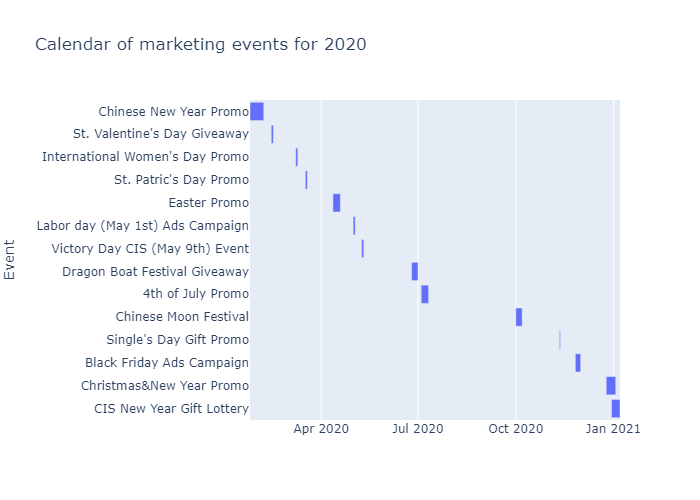

In [24]:
# Visualizing marketing events
fig = px.timeline(marketing_events, x_start="start_dt", x_end="finish_dt", y="name",
                  range_x=[marketing_events.start_dt.min(), marketing_events.finish_dt.max()],
                  hover_data=['name', 'regions', 'start_dt', 'finish_dt'],
                  labels={
                     "name": "Event",
                     "regions": "Region",
                      "start_dt": "Start",
                      "finish_dt": "Finish"},
                  title="Calendar of marketing events for 2020")
fig.show("png") 

- The campaign of 'Christmas & New Year Promo' took place in EU between 2020-12-25 and 2021-01-03, thus it was active during part of the time of the AB-test and might have affected its results.
- Moreover the holiday itself (including the preparations for the holiday) might change both the service and the users' behavior and thus the AB-test results.

In [25]:
InteractiveShell.ast_node_interactivity = "last"

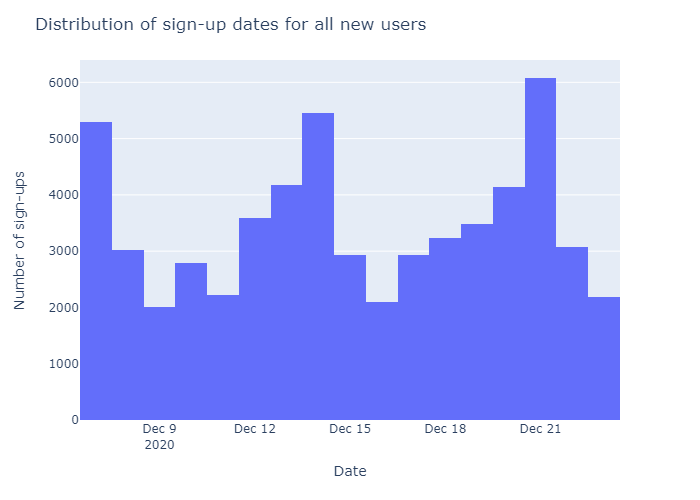

In [26]:
# Plotting sign-ups per date
fig = px.histogram(new_users, x='first_date')
fig.update_layout(
    title="Distribution of sign-up dates for all new users",
    xaxis_title="Date",
    yaxis_title="Number of sign-ups")
fig.show("png") 

- On Mondays, the number of registered users increases: it peaked on December 21st (with 6,077 users signing-up), and there were peaks on the 7th and 14th as well.

In [27]:
# Merging valid_participants and new_users data
participants_new_users = valid_participants.merge(new_users, how="left", on='user_id')

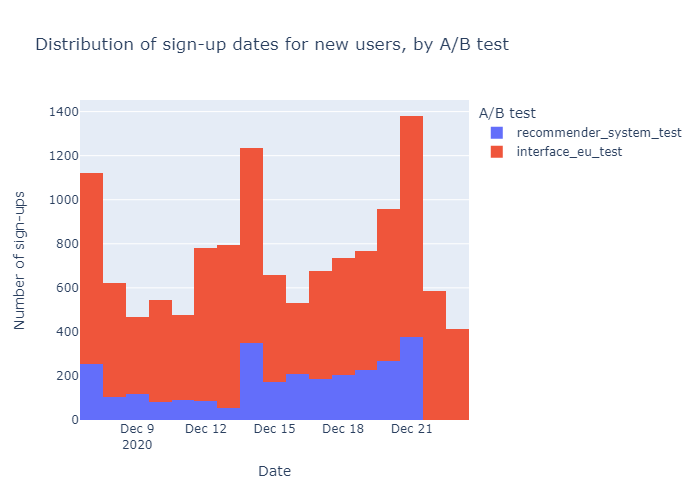

In [28]:
# Plotting sign-ups per date for each of the tests
fig = px.histogram(participants_new_users, x='first_date', color='ab_test',
                  labels={
                     "first_date": "Date",
                     "ab_test": "A/B test"
                 },
                  title="Distribution of sign-up dates for new users, by A/B test")
fig.update_layout(
    yaxis_title="Number of sign-ups")
fig.show("png") 

- Now we can see that in fact the signing-up data for the `recommender_system_test` does end on December 21st as written in the technical description, while it is the `interface_eu_test` assigning that ends two days later.
- Both of the tests show the three peaks: 7, 14 and 21.12.2020.
- Otherwise the dynamics is a bit different, for example in the `recommender_system_test` 13.12 was the lowest and in the `interface_eu_test` it was pretty high.

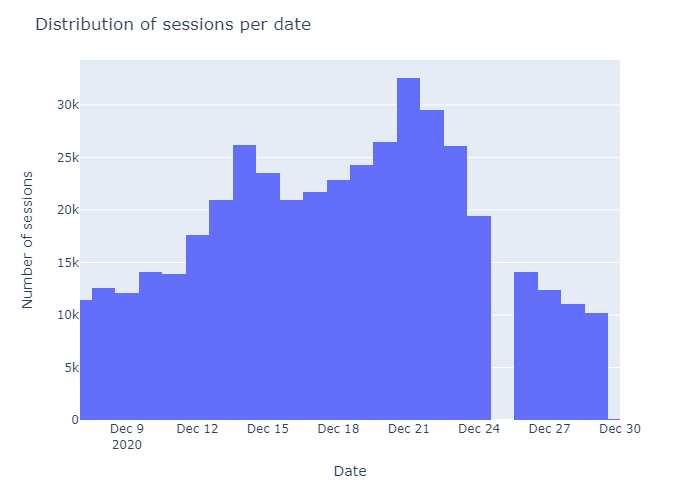

In [29]:
# Plotting sessions per date
fig = px.histogram(events, x='session_date',
                  range_x=[events.session_date.min(), events.session_date.max()])
fig.update_layout(
    title="Distribution of sessions per date",
    xaxis_title="Date",
    yaxis_title="Number of sessions")
fig.show("png") 

- The number of sessions also peaked at December 21st (like the number of sign-ups). There's a peak on the 14th as well.
- The data is missing for December 25th, which was Christmas.
- The period that preceded the holiday (till the 21st) is charachtarized by a rise in sessions.
- After the holiday there was a drastic decrease in sessions.
- On December 30th sessions dropped to almost zero.
- I will consider 7-29.12 as valid dates, though there are many problems with the remaining dates to keep in mind (meaning the effect that the holiday and the campaign of 'Christmas & New Year Promo' might had on the AB-test results.

In [30]:
# Excluding December 30th
events = events.query('event_dt<"2020-12-30"')

### Analysing users

In [31]:
# Examining the distribution of tests and groups
tests_groups = valid_participants.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='nunique').reset_index()
tests_groups['Total']= tests_groups.A+tests_groups.B
tests_groups

group,ab_test,A,B,Total
0,interface_eu_test,5011,4952,9963
1,recommender_system_test,2082,706,2788


- `recommender_system_test` consists only of 2,788 users, and only 706 of them are in the test (B) group. While expected number of test participants was 6,000.
- `interface_eu_test` consists of 9,963 users, quite evenely split between the A/B groups.

**Treating regions**

In [32]:
# Audience is supposed to be 15% of the new users from the EU region
new_users.query('region=="EU"')['user_id'].nunique()*0.15

6509.4

Audience is supposed to be 15% of the new users from the EU region => 6,509 users. We can already see that the number of users in the `recommender_system_test` is lower. The number of users in the  `interface_eu_test` on the other hand is higher. Next I will check the distribution of regions for both tests.

In [33]:
# Seperating the A/B tests
recommender_participants_users = participants_new_users.query('ab_test=="recommender_system_test"').drop(columns='ab_test')
interface_participants_users = participants_new_users.query('ab_test=="interface_eu_test"').drop(columns='ab_test')

In [34]:
# Checking the distribution of regions among the recommender_system_test users
recommender_participants_users.stb.freq(['region'], style=True)

,region,count,percent,cumulative_count,cumulative_percent
0,EU,"2,594",93.04%,"2,594",93.04%
1,N.America,119,4.27%,"2,713",97.31%
2,APAC,45,1.61%,"2,758",98.92%
3,CIS,30,1.08%,"2,788",100.00%


- Audience of `recommender_system_test` is supposed to be users from the EU region, but there are other regions too (7% of the users).

In [35]:
# Checking the percentage of EU among the users of group A vs. group B 
print("Percentage of EU among group A: {:.2%}".format(len(recommender_participants_users.query('group=="A" & region=="EU"'))/len(recommender_participants_users.query('group=="A"'))))
"Percentage of EU among group B: {:.2%}".format(len(recommender_participants_users.query('group=="B" & region=="EU"'))/len(recommender_participants_users.query('group=="B"')))

Percentage of EU among group A: 93.13%


'Percentage of EU among group B: 92.78%'

- The percentage of EU is similar in both of the groups of `recommender_system_test`.

In [36]:
# Checking the distribution of regions among the interface_eu_test users
interface_participants_users.stb.freq(['region'], style=True)

,region,count,percent,cumulative_count,cumulative_percent
0,EU,"9,963",100.00%,"9,963",100.00%


- All the `interface_eu_test` users are from EU.

In [37]:
interface_participants_users = interface_participants_users.drop(columns='region')

In [38]:
# Checking the distribution of regions among all the new users
new_users.stb.freq(['region'], style=True)

,region,count,percent,cumulative_count,cumulative_percent
0,EU,"43,396",73.92%,"43,396",73.92%
1,N.America,"9,051",15.42%,"52,447",89.34%
2,CIS,"3,130",5.33%,"55,577",94.67%
3,APAC,"3,126",5.33%,"58,703",100.00%


- The percentage of EU among all the new users is lower than in the `recommender_system_test` - 74% vs. 93%.
- I believe that other regions were included in the `recommender_system_test` by mistake => I will remove them.

In [39]:
# Selecting only EU users
recommender_participants_users = recommender_participants_users.query('region=="EU"').drop(columns='region')
recommender_participants_users

,user_id,group,first_date,device
0,D1ABA3E2887B6A73,A,2020-12-07,PC
1,A7A3664BD6242119,A,2020-12-20,iPhone
2,4FF2998A348C484F,A,2020-12-20,Mac
3,7473E0943673C09E,A,2020-12-16,iPhone
4,C46FE336D240A054,A,2020-12-17,iPhone
...,...,...,...,...
2589,700E7D23A9A81AE3,B,2020-12-16,Android
2590,7C5C12FA1B5AB710,A,2020-12-21,Android
2591,91C3969B8A72B908,B,2020-12-09,Android
2592,E26F13A65CEAC6EA,A,2020-12-17,Mac


In [40]:
"Audience of the `recommender_system_test` is {:.0%} of the new users from the EU region ({} users)".format(len(recommender_participants_users)/new_users.query('region=="EU"')['user_id'].nunique(),len(recommender_participants_users) )

'Audience of the `recommender_system_test` is 6% of the new users from the EU region (2594 users)'

In [41]:
"Audience of the `interface_eu_test` is {:.0%} of the new users from the EU region ({} users)".format(len(interface_participants_users)/new_users.query('region=="EU"')['user_id'].nunique(),len(interface_participants_users))

'Audience of the `interface_eu_test` is 23% of the new users from the EU region (9963 users)'

**Treating devices**

In [42]:
def device_group (df, group):
    """
    Checks the distribution of devices for each group of each test
    df: data of each test
    group: instances of `group` column
    return: frequency table
    """
    return df[df['group']==group].stb.freq(['device'], style=True)

In [43]:
device_group(recommender_participants_users, 'A')

,device,count,percent,cumulative_count,cumulative_percent
0,Android,858,44.25%,858,44.25%
1,PC,504,25.99%,"1,362",70.24%
2,iPhone,400,20.63%,"1,762",90.87%
3,Mac,177,9.13%,"1,939",100.00%


In [44]:
device_group(recommender_participants_users, 'B')

,device,count,percent,cumulative_count,cumulative_percent
0,Android,309,47.18%,309,47.18%
1,PC,158,24.12%,467,71.30%
2,iPhone,130,19.85%,597,91.15%
3,Mac,58,8.85%,655,100.00%


- Group B of the `recommender_system_test` used Android a little more (47% vs. 44%), and PC a little less (24% vs. 26%), but the differences seem relatively small.

In [45]:
device_group(interface_participants_users, 'A')

,device,count,percent,cumulative_count,cumulative_percent
0,Android,"2,218",44.26%,"2,218",44.26%
1,PC,"1,302",25.98%,"3,520",70.25%
2,iPhone,980,19.56%,"4,500",89.80%
3,Mac,511,10.20%,"5,011",100.00%


In [46]:
device_group(interface_participants_users, 'B')

,device,count,percent,cumulative_count,cumulative_percent
0,Android,"2,264",45.72%,"2,264",45.72%
1,PC,"1,223",24.70%,"3,487",70.42%
2,iPhone,950,19.18%,"4,437",89.60%
3,Mac,515,10.40%,"4,952",100.00%


- The distribution of devices for group A vs. B of `interface_eu_test` seems similar enough.

### Analysing events

#### In general

In [47]:
# Calculating the number of actions per user
event_user_count = events.groupby('user_id').agg({'event_name':'count'}).reset_index()
f"The average number of actions per user is {round(event_user_count.event_name.mean(),2)}"

'The average number of actions per user is 7.22'

In [48]:
# Examining the descriptive statistics of the number of actions per user
event_user_count.event_name.describe()

count    58703.000000
mean         7.217212
std          4.121021
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         36.000000
Name: event_name, dtype: float64

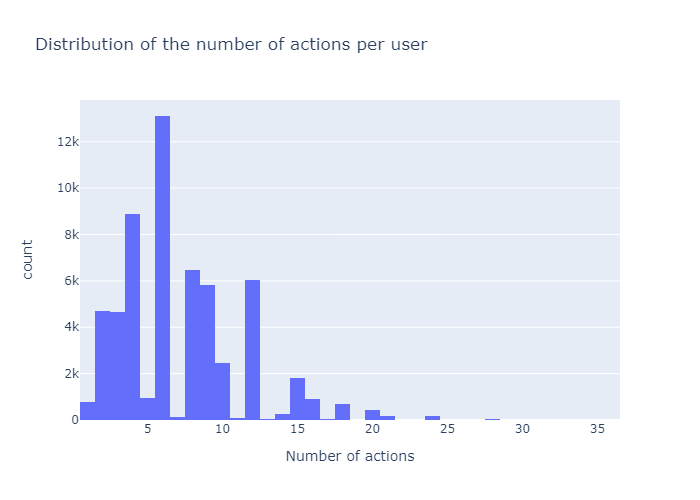

In [49]:
# Plotting the number of actions per user
fig = px.histogram(event_user_count, x="event_name", 
                   title="Distribution of the number of actions per user",
                  labels={"event_name":"Number of actions"})
fig.show("png") 

- When looking at the total actions per user (including repetitions of events), we see that the distribution is positively skewed with an average of 7 actions and a median of 6.
- Most of the users perform 1-9 actions.

In [50]:
# Looking at the different events and their frequency 
events['event_name'].value_counts()

login           182429
product_page    120840
purchase         60299
product_cart     60104
Name: event_name, dtype: int64

In [51]:
# Calculating the number of users who performed each of the actions
event_funnel = events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
event_funnel= event_funnel.rename(columns={"user_id": "num_users"})
event_funnel

,event_name,num_users
0,login,58696
1,product_page,38929
2,purchase,19568
3,product_cart,19284


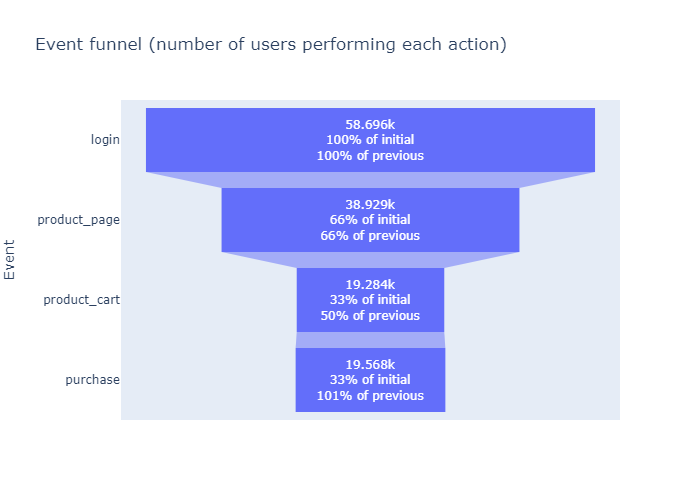

In [52]:
# Plotting the event funnel (according to the order: login → product_page → product_cart → purchase)
fig = go.Figure(layout=go.Layout(
        title=go.layout.Title(text="Event funnel (number of users performing each action)"),
    yaxis_title="Event"))
fig.add_trace(go.Funnel(y=event_funnel.loc[[0,1,3,2], 'event_name'],
                        x=event_funnel.loc[[0,1,3,2], 'num_users'],
                        textposition= "inside",
                        textinfo="value+percent initial+percent previous"))
fig.show("png") 

- We lose the most users at the product_cart stage.
- Only a third of the users make it to the purchase.

#### For each test

In [53]:
# Getting the events of each test
recommender_events = recommender_participants_users.merge(events, on='user_id')
interface_events = interface_participants_users.merge(events, on='user_id')

According to the technical description of the Recommender test, we need to study the data on events that were provided in the first 14 days after registration, becuase we're supposed to get the expected result until then. Therefore for this test I will filter out events that occured more than 14 days after registration.

In [54]:
# Selecting only events that occured 14 days or less after registration
recommender_events = recommender_events[((recommender_events.session_date-recommender_events.first_date).astype('timedelta64[D]'))<=14]
print(recommender_events)
# Making sure that I didn't lose any users
recommender_events.user_id.nunique()

                user_id group first_date   device            event_dt  \
0      D1ABA3E2887B6A73     A 2020-12-07       PC 2020-12-07 14:43:27   
1      D1ABA3E2887B6A73     A 2020-12-07       PC 2020-12-07 14:43:29   
2      D1ABA3E2887B6A73     A 2020-12-07       PC 2020-12-07 14:43:27   
3      D1ABA3E2887B6A73     A 2020-12-07       PC 2020-12-07 14:43:27   
4      A7A3664BD6242119     A 2020-12-20   iPhone 2020-12-20 15:46:06   
...                 ...   ...        ...      ...                 ...   
16952  80712ED4EA1B52A5     A 2020-12-14  Android 2020-12-15 20:10:06   
16953  80712ED4EA1B52A5     A 2020-12-14  Android 2020-12-20 20:01:34   
16954  80712ED4EA1B52A5     A 2020-12-14  Android 2020-12-14 05:48:50   
16955  80712ED4EA1B52A5     A 2020-12-14  Android 2020-12-15 20:10:03   
16956  80712ED4EA1B52A5     A 2020-12-14  Android 2020-12-20 20:01:32   

         event_name  details session_date  
0          purchase    99.99   2020-12-07  
1      product_cart      NaN   2020

2594

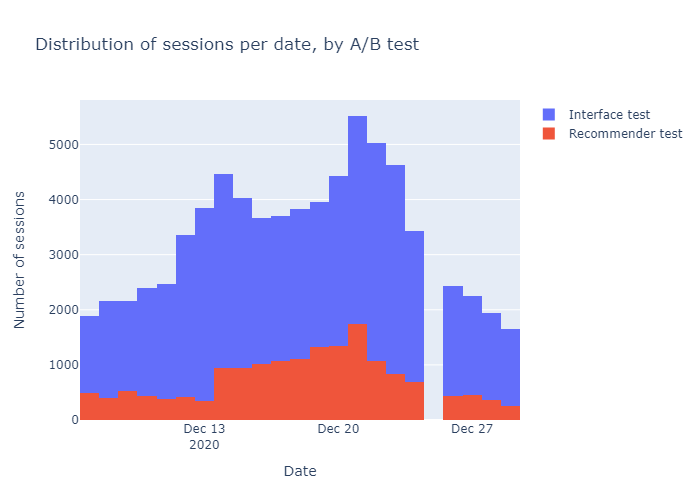

In [55]:
# Plotting sessions per date, by A/B test
fig = go.Figure(layout=go.Layout(
        title=go.layout.Title(text="Distribution of sessions per date, by A/B test"),
    xaxis_title= "Date", yaxis_title="Number of sessions", barmode='overlay'))
fig.add_trace(go.Histogram(name='Interface test' , x=interface_events.session_date))
fig.add_trace(go.Histogram(name='Recommender test' , x=recommender_events.session_date))
fig.show("png") 

- The number of sessions peaked at December 21st for both of the tests. The peak that we saw on the 14th belongs to the `interface_eu_test`.
- Both tests show a rise in sessions before the 21st and a drastic decrease after the holiday.
- In the `recommender_system_test` the 13th was the lowest and in the `interface_eu_test` it was pretty high (like we saw with the number of sign-ups).

In [56]:
def plot_sessions(df, df_name):
    """
    Plots a sessions per date histogram for each test, by group
    df: data of each test
    df_name: name of each test
    """
    fig = px.histogram(df, x='session_date', color='group',
                       barmode='overlay',
                  labels={
                     "session_date": "Date",
                     "group": "Group"
                 },
                  title=f"{df_name}- Distribution of sessions per date, by group")
    fig.update_layout(
        yaxis_title="Number of sessions")
    fig.show("png") 

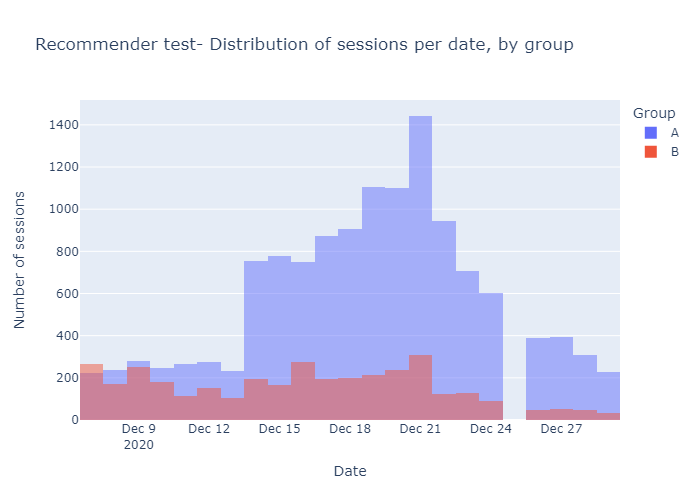

In [57]:
plot_sessions(recommender_events, "Recommender test")

- In `recommender_system_test`, the number of sessions of group A is consistently higher in comparison to group B, except for December 7th.
- Group A's numbers sharply jumped on the 14th and the effect of the holiday (including the peak on the 21st) mainly belongs to this group.

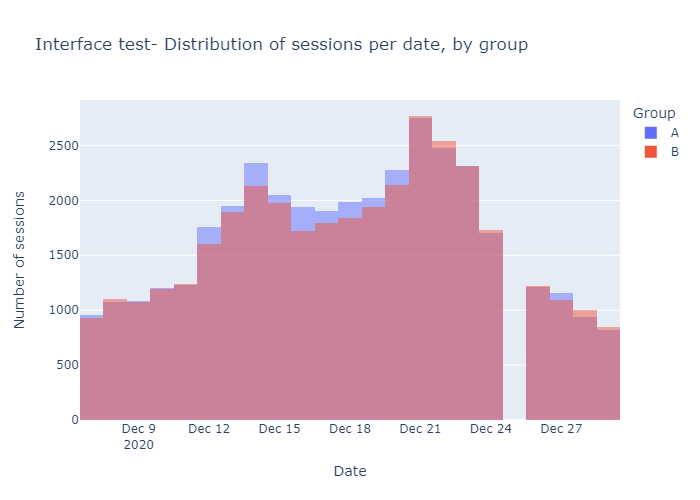

In [58]:
plot_sessions(interface_events, "Interface test")

- In the `interface_eu_test`, the number of sessions of the two groups is quite similar during the whole period.
- On December 12-20 group A's numbers somewhat exceeded those of group B.

In [59]:
# Calculating the number of actions per user for each of the tests 
recommender_events_count = recommender_events.groupby('user_id').agg({'event_name':'count','group':'max'}).reset_index()
interface_events_count = interface_events.groupby('user_id').agg({'event_name':'count','group':'max'}).reset_index()

In [60]:
def number_actions(df_name, df):
    """
    Prints the average number of actions per user for each test & group and shows a boxplot
    df: data of each test
    df_name: name of each test
    """
    print(f"The average number of actions per user in {df_name} in general is {round(df.event_name.mean(),2)}")
    print(f"The average number of actions per user in group A is {round(df[df['group']=='A'].event_name.mean(),2)}")
    print(f"The average number of actions per user in group B is {round(df[df['group']=='B'].event_name.mean(),2)}")
    fig = px.box(df, x="group", y="event_name",
             title=f"{df_name}, A vs. B - Distribution of the number of actions per user",
                  labels={"event_name":"Number of actions per user"})
    fig.show("png") 

The average number of actions per user in recommender_system_test in general is 6.39
The average number of actions per user in group A is 6.73
The average number of actions per user in group B is 5.4


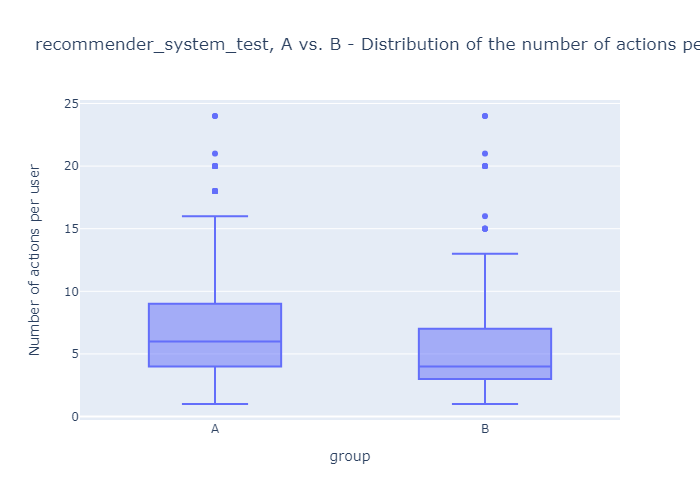

In [61]:
number_actions('recommender_system_test',recommender_events_count)

- It seems that in `recommender_system_test`, group A's users made more actions in comparison to group B (their mean, median, Q3 and upper fence are higher). It's hard to tell whether the difference is due to the changes we are testing or it is due to a mistake in assigning the groups in the first place.

The average number of actions per user in interface_eu_test in general is 7.35
The average number of actions per user in group A is 7.41
The average number of actions per user in group B is 7.29


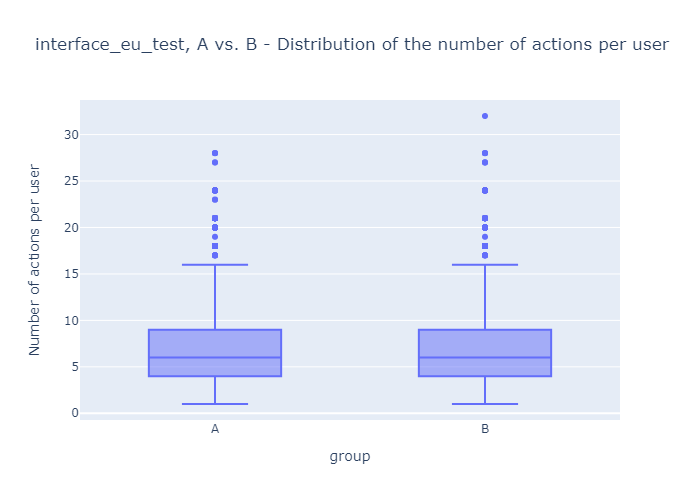

In [62]:
number_actions('interface_eu_test',interface_events_count)

- It seems that in `interface_eu_test`, the two groups' users made a similar number of actions (their mean is relatively similar, and their median, Q3 and upper fence are the same).

In [63]:
# Calculating the number of `recommender_system_test` users who performed each action, in each of the groups
recommender_events_users = recommender_events.groupby(['group','event_name'])['user_id'].nunique().reset_index().sort_values(by=['group','user_id'], ascending=False)
recommender_events_users= recommender_events_users.rename(columns={"user_id": "num_users"})
recommender_events_users

,group,event_name,num_users
4,B,login,654
6,B,product_page,367
7,B,purchase,191
5,B,product_cart,184
0,A,login,1939
2,A,product_page,1265
3,A,purchase,613
1,A,product_cart,589


In [64]:
# Calculating the number of `interface_eu_test` users who performed each action, in each of the groups
interface_events_users = interface_events.groupby(['group','event_name'])['user_id'].nunique().reset_index().sort_values(by=['group','user_id'], ascending=False)
interface_events_users= interface_events_users.rename(columns={"user_id": "num_users"})
interface_events_users

,group,event_name,num_users
4,B,login,4952
6,B,product_page,3254
5,B,product_cart,1686
7,B,purchase,1653
0,A,login,5010
2,A,product_page,3366
3,A,purchase,1782
1,A,product_cart,1629


In [65]:
def plot_funnel(df_name, df):
    """
    Plots a funnel for each test, by group
    df: data of each test
    df_name: name of each test
    """
    fig = go.Figure(layout=go.Layout(
        title=go.layout.Title(text=f"{df_name} - Event funnel by group"),
        yaxis_title="Event"))
    fig.add_trace(go.Funnel(name= 'group A',
                        y=df.loc[[0,2,1,3], 'event_name'],
                        x=df.loc[[0,2,1,3], 'num_users'],
                        textposition= "inside",
                        textinfo="value+percent initial+percent previous"))
    fig.add_trace(go.Funnel(name= 'group B',
                        y=df.loc[[4,6,5,7], 'event_name'],
                        x=df.loc[[4,6,5,7], 'num_users'],
                        textposition= "auto",
                        textinfo="value+percent initial+percent previous"))
    fig.show("png") 

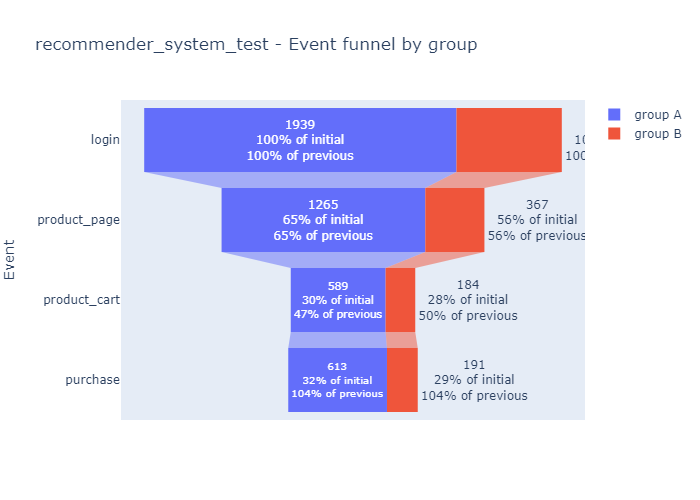

In [66]:
plot_funnel('recommender_system_test',recommender_events_users)

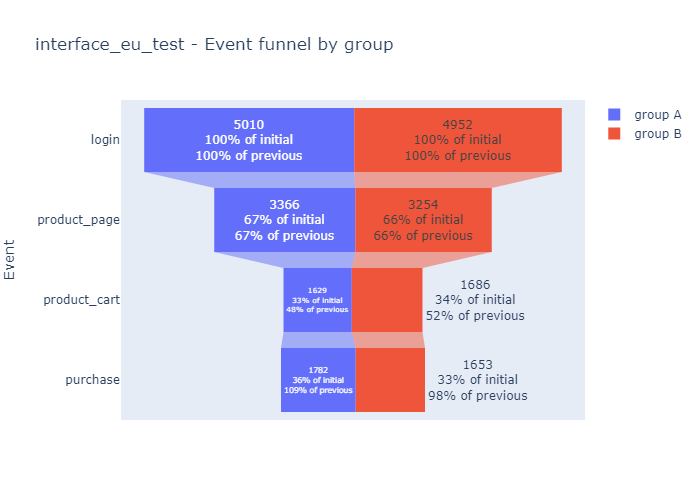

In [67]:
plot_funnel('interface_eu_test',interface_events_users)

The funnels show that for both of the tests group B did not perform better than group A, and in fact it mostly performed worse. The most noticeable difference is in the `recommender_system_test`, where the control group showed a better conversion into product page views (65% vs. 56%).
Therefore, the expected results whereby there will be at least a 10% increase at each stage of the funnel are not met.

#### For each device

In [68]:
# Calculating the number of actions per user & device for each of the tests 
recommender_events_device = recommender_events.groupby(['device','group','user_id']).agg({'event_name':'count'}).reset_index()
interface_events_device = interface_events.groupby(['device','group','user_id']).agg({'event_name':'count'}).reset_index()

In [69]:
print("Recommender test - average number of actions per user for each device & group:")
recommender_events_device.pivot_table(index='device', columns='group', values='event_name').sort_values(by=['A'], ascending=False)

Recommender test - average number of actions per user for each device & group:


group,A,B
device,,
Mac,7.135593,5.362069
iPhone,6.925000,5.846154
Android,6.628205,5.504854
PC,6.589286,4.860759


- For both of the groups PC has the lowest average number of actions per user.
- For group A Mac is the leader, while it comes in 3rd place for group B.
- For group B iPhone is the leader.

In [70]:
print("Interface test - average number of actions per user for each device & group:")
interface_events_device.pivot_table(index='device', columns='group', values='event_name').sort_values(by=['A'], ascending=False)

Interface test - average number of actions per user for each device & group:


group,A,B
device,,
iPhone,7.645918,7.171579
Mac,7.589041,7.423301
PC,7.354071,7.269828
Android,7.293508,7.310071


- For group A iPhone is the leader and Android is the last.
- For group B Mac is the leader and iPhone is the last.

### Summary of EDA

**Dates:**
- The campaign of 'Christmas & New Year Promo' took place during part of the time of the A/B test and might have affected its results, in addition to the effect of the holiday itself.
<br>

- The signing-up data for the `recommender_system_test` does end on December 21st as written in the technical description, while it is the `interface_eu_test` assigning that ends two days later.
<br>
- The overall number of sign-ups peaked at December 21st. There were peaks on the 7th and 14th as well. Both of the tests show the three signing-up peaks.
<br>
- The number of sessions also peaked at December 21st, for both of the tests. In the `interface_eu_test` there was another peak on the 14th.
<br>
- The sessions' data is missing for December 25th, which was Christmas.
<br>
- There was a rise in sessions before the 21st, and a drastic decrease after the holiday.
<br>
- On December 30th sessions dropped to almost zero, therefore I excluded this date from the analysis.
<br>
- On the 13th, both the number of sign-ups and the number of sessions were the lowest in the `recommender_system_test` and pretty high in the `interface_eu_test`.
<br>

**Users:**
- Out of the initially 12,751 valid participants:
    - `recommender_system_test` consists only of 2,594 users, and only about a third of them are in the test (B) group. While expected number of test participants was 6,000.
    - `interface_eu_test` consists of 9,963 users, quite evenely split between the A/B groups.<br>
<br>

- Audience of `recommender_system_test` is supposed to be users from the EU region, but there are other regions too (7% of the users).
<br>
- The percentage of EU is similar in both of the groups of `recommender_system_test`.
<br>
- All the `interface_eu_test` users are from EU.
<br>
- The percentage of EU among all the new users is lower than in the recommender_system_test - 74% vs. 93%.
<br>
- I figured that other regions were included in the `recommender_system_test` by mistake so I decided to remove them.
<br>
- Audience is supposed to be 15% of the new users from the EU region => 6,509 users. However, audience of the `recommender_system_test` is only 6%.
<br>
- Audience of the `interface_eu_test` is 23% of the new users from the EU region.
<br>
- Group B of the `recommender_system_test` used Android a little more (47% vs. 44%), and PC a little less (24% vs. 26%), but the differences seem relatively small.
<br>
- The distribution of devices for group A vs. B of `interface_eu_test` seems similar enough.
<br>

**Events:**
- In general:
    - The average number of actions per user is 7.22.
    - The distribution of the number of actions per user is positively skewed with an average of 7 actions and a median of 6. Most of the users perform 1-9 actions.
    - We lose the most users at the product_cart stage.
    - Only a third of the users make it to the purchase.<br>
<br>
- For each test:
    - For the `recommender_system_test` I filtered out events that occured more than 14 days after registration, in order to meet the requirement of the technical description.
    - It seems that in `recommender_system_test`, group A's users made more actions in comparison to group B. It's hard to tell whether the difference is due to the changes we are testing or it is due to a mistake in assigning the groups in the first place.
    - It seems that in `interface_eu_test`, the two groups' users made a similar number of actions.
    - The event funnels show that for both of the tests group B did not perform better than group A, and in fact it mostly performed worse. The most noticeable difference is in the `recommender_system_test`, where the control group showed a better conversion into product page views (65% vs. 56%). Therefore, the expected results whereby there will be at least a 10% increase at each stage of the funnel are not met.<br>
<br>
- For each device:
    - In the `recommender_system_test`:
        - For both of the groups PC has the lowest average number of actions per user.
        - For group A Mac is the leader, while it comes in 3rd place for group B.
        - For group B iPhone is the leader.
        
    - In the `interface_eu_test`:
        - For group A iPhone is the leader and Android is the last.
        - For group B Mac is the leader and iPhone is the last.


## Evaluation of the A/B test results

In [71]:
# Looking at the number of users in each group of the `recommender_system_test`
recommender_group_users = recommender_participants_users.groupby('group').agg({'user_id': 'nunique'}).reset_index()
recommender_group_users

,group,user_id
0,A,1939
1,B,655


In [72]:
# Looking at the number of users in each group of the `interface_eu_test`
interface_group_users = interface_participants_users.groupby('group').agg({'user_id': 'nunique'}).reset_index()
interface_group_users

,group,user_id
0,A,5011
1,B,4952


In [73]:
# Merging the number of users who performed each action with the total number of users in each group, for each test
recommender_group_events_users = recommender_events_users.merge(recommender_group_users, how='right', on="group")
recommender_group_events_users= recommender_group_events_users.rename(columns={"user_id": "total_users"})

interface_group_events_users = interface_events_users.merge(interface_group_users, how='right', on="group")
interface_group_events_users= interface_group_events_users.rename(columns={"user_id": "total_users"})

print(recommender_group_events_users)
interface_group_events_users

  group    event_name  num_users  total_users
0     A         login       1939         1939
1     A  product_page       1265         1939
2     A      purchase        613         1939
3     A  product_cart        589         1939
4     B         login        654          655
5     B  product_page        367          655
6     B      purchase        191          655
7     B  product_cart        184          655


,group,event_name,num_users,total_users
0,A,login,5010,5011
1,A,product_page,3366,5011
2,A,purchase,1782,5011
3,A,product_cart,1629,5011
4,B,login,4952,4952
5,B,product_page,3254,4952
6,B,product_cart,1686,4952
7,B,purchase,1653,4952


**Performing an A/A test**

The technical decription doesn't include an A/A test and there's no explicit data on a second control group. For the sake of the drill, since an A/A test is important in order to check our mechanisms and calculations, and since the data includes users who weren't assigned to any test, I will create another control group for each test and check whether there is a statistically significant difference between the control groups.

In [74]:
# Creating a list of EU users who weren't assigned to any test
no_test_users = new_users.query('user_id not in @participants.user_id & region=="EU"').user_id.tolist()

# Random sampling from the list into two seperate control groups - one for each test
control_for_recommender = sample(no_test_users,recommender_group_users.loc[0,'user_id'])
no_test_users_updated = [user_id for user_id in no_test_users if user_id not in control_for_recommender]
control_for_interface = sample(no_test_users_updated,interface_group_users.loc[0,'user_id'])

print(len(control_for_recommender))
len(control_for_interface)

1939


5011

In [75]:
# Making sure that there is no intersection between the samples
if (set(control_for_recommender) & set(control_for_interface)):
    True 
else:
    False

False

In [76]:
# Preparing the data for the control groups
recommender_control_events = events.query('user_id in @control_for_recommender')
interface_control_events = events.query('user_id in @control_for_interface')

In [77]:
# Calculating the number of users who performed each action, for each of the tests
recommender_control_event_users = recommender_control_events.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
recommender_control_event_users= recommender_control_event_users.rename(columns={"user_id": "num_users"})

interface_control_event_users = interface_control_events.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
interface_control_event_users = interface_control_event_users.rename(columns={"user_id": "num_users"})

print(recommender_control_event_users)
interface_control_event_users

     event_name  num_users
0         login       1939
2  product_page       1295
3      purchase        676
1  product_cart        636


,event_name,num_users
0,login,5010
2,product_page,3362
3,purchase,1785
1,product_cart,1681


In [78]:
# Adding the total number of users in each control group
recommender_control_event_users['total_users']= len(control_for_recommender)
interface_control_event_users['total_users']= len(control_for_interface)

H0: The difference between the two control groups is statistically insignificant.

H1: The difference between the two control groups is statistically significant.

I wish to carry out 6 statistical hypothesis tests, comparing 3 events for both A/A and A/B, for each of the recommender/interface tests seperately. I will use Bonferroni correction in order to calculate the appropriate significance level for the multiple testing.

In [79]:
# Calculating the appropriate significance level
significance = 0.05/6
significance

0.008333333333333333

In [80]:
def test_AA (df_control, action, df_test):
    """
    Performs a statistical test for the difference in the proportion of each of the events, between the control groups
    df_control: data of the added control group for each test
    action: each of the events
    df_test: data of each test
    """
    successes = np.array([df_control[df_control['event_name']==action]['num_users'], df_test[(df_test['group']=="A") & (df_test['event_name']==action)]['num_users']])
    samples = np.array([df_control[df_control['event_name']==action]['total_users'], df_test[(df_test['group']=="A") & (df_test['event_name']==action)]['total_users']])

    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    print(f"Results for the share of users who performed the action: {action}")

    print ('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
    if p_value > significance:
       print ("Fail to reject H0 - the difference between the two control groups is statistically insignificant")
    else:
       print ("Reject Ho - the difference between the two control groups is statistically significant")
    print()

In [81]:
# Applying the function to the list of events for the `recommender_system_test`, excluding the login

print("Difference between the `recommender_system_test` control groups:")
for action in events.event_name.unique()[0:3]:
    test_AA (recommender_control_event_users, action, recommender_group_events_users)

Difference between the `recommender_system_test` control groups:
Results for the share of users who performed the action: purchase
z_stat: 2.148, p_value: 0.032
Fail to reject H0 - the difference between the two control groups is statistically insignificant

Results for the share of users who performed the action: product_cart
z_stat: 1.624, p_value: 0.104
Fail to reject H0 - the difference between the two control groups is statistically insignificant

Results for the share of users who performed the action: product_page
z_stat: 1.017, p_value: 0.309
Fail to reject H0 - the difference between the two control groups is statistically insignificant



In [82]:
# Applying the function to the list of events for the `interface_eu_test`, excluding the login

print("Difference between the `interface_eu_test` control groups:")
for action in events.event_name.unique()[0:3]:
    test_AA (interface_control_event_users, action, interface_group_events_users)

Difference between the `interface_eu_test` control groups:
Results for the share of users who performed the action: purchase
z_stat: 0.063, p_value: 0.950
Fail to reject H0 - the difference between the two control groups is statistically insignificant

Results for the share of users who performed the action: product_cart
z_stat: 1.104, p_value: 0.269
Fail to reject H0 - the difference between the two control groups is statistically insignificant

Results for the share of users who performed the action: product_page
z_stat: -0.085, p_value: 0.932
Fail to reject H0 - the difference between the two control groups is statistically insignificant



I failed to reject H0 for each of the tests and for each of the events, meaning the difference between the two control groups in each of the tests is statistically insignificant. Therefore I conclude that the groups were split properly.

In [83]:
def test_AB (df_test, action):
    """
    Performs a statistical test for the difference in the proportion of each of the events, between groups A and B
    df_test: data of each test
    action: each of the events
    """
    successes = np.array([df_test[(df_test['group']=="A") & (df_test['event_name']==action)]['num_users'], df_test[(df_test['group']=="B") & (df_test['event_name']==action)]['num_users']])
    samples = np.array([df_test[(df_test['group']=="A") & (df_test['event_name']==action)]['total_users'], df_test[(df_test['group']=="B") & (df_test['event_name']==action)]['total_users']])

    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    print(f"Results for the share of users who performed the action: {action}")

    print ('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
    if p_value > significance:
       print ("Fail to reject H0 - the difference between the control group and the test group is statistically insignificant")
    else:
       print ("Reject Ho - the difference between the control group and the test group is statistically significant")
    print()

In [84]:
# Applying the function to the list of events for the `recommender_system_test`, excluding the login

print("Difference between the `recommender_system_test` A/B groups:")
for action in events.event_name.unique()[0:3]:
    test_AB (recommender_group_events_users, action)

Difference between the `recommender_system_test` A/B groups:
Results for the share of users who performed the action: purchase
z_stat: 1.174, p_value: 0.240
Fail to reject H0 - the difference between the control group and the test group is statistically insignificant

Results for the share of users who performed the action: product_cart
z_stat: 1.105, p_value: 0.269
Fail to reject H0 - the difference between the control group and the test group is statistically insignificant

Results for the share of users who performed the action: product_page
z_stat: 4.219, p_value: 0.000
Reject Ho - the difference between the control group and the test group is statistically significant



In [85]:
# Applying the function to the list of events for the `interface_eu_test`, excluding the login

print("Difference between the `interface_eu_test` A/B groups:")
for action in events.event_name.unique()[0:3]:
    test_AB (interface_group_events_users, action)

Difference between the `interface_eu_test` A/B groups:
Results for the share of users who performed the action: purchase
z_stat: 2.290, p_value: 0.022
Fail to reject H0 - the difference between the control group and the test group is statistically insignificant

Results for the share of users who performed the action: product_cart
z_stat: -1.629, p_value: 0.103
Fail to reject H0 - the difference between the control group and the test group is statistically insignificant

Results for the share of users who performed the action: product_page
z_stat: 1.545, p_value: 0.122
Fail to reject H0 - the difference between the control group and the test group is statistically insignificant



I failed to reject H0 in most of the statistical tests, except for the one that checked the difference in product page views in the `recommender_system_test`, where I found a reversed statistically significant difference between the control group and the test group, meaning that the control group did better than the test group. The rest of the statistical tests showed that the difference between the control group and the test group in each of the recommender/interface tests is statistically insignificant.

Therefore I conclude that for both of the recommender/interface tests the changes that were tested did not produce better results, and the expected results whereby users will show better conversion into product page views, instances of adding items to the shopping cart, and purchases, and there will be at least a 10% increase at each stage of the funnel, are not met.

### Summary of evaluation of A/B results

- I calculated the number of users who performed each action as well as the total number of users, in each of the groups for each of the A/B tests.


- For the sake of the drill, I created another control group for each test (using random sampling) and carried out A/A tests.


- I used Bonferroni correction in order to calculate the appropriate significance level for the multiple testing (6 statistical hypothesis tests: comparing 3 events for both A/A and A/B, for each of the recommender/interface tests seperately).


- In the A/A tests I failed to reject H0 for any of the events, meaning the difference between the two control groups in each of the tests was statistically insignificant.


- In the A/B tests I failed to reject H0 most of the times, except for the one that checked the difference in product page views in the `recommender_system_test`, where I found a reversed statistically significant difference between the control group and the test group, meaning that the control group did better than the test group. The rest of the statistical tests showed that the difference between the control group and the test group in each of the recommender/interface tests is statistically insignificant.

## Conclusions and recommendations
- The overlaping of Christmas and the campaign of 'Christmas & New Year Promo' with the time of the A/B tests is a problem that undermines their legitimacy in the first place, since those events might change both the service and the users' behavior and thus the A/B test results.


- Splitting into A/B groups was not valid, because the two A/B tests overlapped and some of the users were mistakenly assigned to both of them simultaneously.


- Not having A/A tests is also problematic. For the sake of the drill, I performed A/A tests myself and they were successful, showing that the control groups were split properly.


- The A/B tests were not successful in the sense that for both of the recommender/interface tests the changes that were tested did not produce better results, and the expected results whereby users will show better conversion into product page views, instances of adding items to the shopping cart, and purchases, and there will be at least a 10% increase at each stage of the funnel, were not met.


- These results can't be trusted because the tests were carried out with all the violations mentioned previously.


**Recommendations:**

- To check the splitting system
- To repeat the test, this time properly
- To carry out the test in a different time of the year (without holidays and marketing events)